In [3]:
"""
from OptimizedDataGenerator4 import *
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras_tuner as kt
noGPU=False
if noGPU:
    tf.config.set_visible_devices([], 'GPU')

print("\nHIIIIIIIIIIIIIIIIII\n")

print(tf.config.experimental.list_physical_devices())
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print(tf.test.is_gpu_available())
"""

from abc import ABC, abstractmethod
# import all the necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay, ExponentialDecay, CosineDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from sklearn.metrics import roc_curve, auc
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/local/d1/smartpixML/filtering_models/shuffling_data/") #TODO use the ODG from here
import OptimizedDataGenerator4_data_shuffled_bigData as ODG2
import pandas as pd
from datetime import datetime
sys.path.append("../ryan")
import OptimizedDataGenerator4 as ODG


sys.path.append(str(Path.cwd().parents[0]))

from MuC_Smartpix_ML.Model_Classes import SmartPixModel
print(SmartPixModel)

<class 'MuC_Smartpix_ML.Model_Classes.SmartPixModel'>


In [4]:
class Model1(SmartPixModel):
    def __init__(self,
            tfRecordFolder: str = "/local/d1/smartpixML/filtering_models/shuffling_data/all_batches_shuffled_bigData_try2/filtering_records16384_data_shuffled_single_bigData/",
            nBits: list = None, # just for fractional bits, integer bits
                                ## number of bits is the number of bits for each quantized model and then
                                ## run training should make one model for each bit size
            loadModel: bool = False,
            modelPath: str = None, # Only include if you are loading a model
                        # dropout_rate: float = 0.1,
            initial_lr: float = 1e-3,
            end_lr: float = 1e-4,
            power: int = 2,
            bit_configs = [(16, 0), (8, 0), (6, 0), (4, 0), (3, 0), (2, 0)]  # Test 16, 8, 6, 4, 3, and 2-bit quantization
            ): 
        self.tfRecordFolder = tfRecordFolder
        self.modelName = "Model1" # for other models, e.g., Model 1, Model 2, etc.
        # self.model = None
        self.histories = {}
        self.models = {"Unquantized": None}
        self.bit_configs = bit_configs
        for total_bits, int_bits in self.bit_configs:
            config_name = f"quantized_{total_bits}w{int_bits}i"
            self.models[config_name] = None
        # self.quantized_model = None
        self.hyperparameterModel = None
        self.training_generator = None
        self.validation_generator = None
        self.x_feature_description: list = ['z_global','x_size', 'y_size', 'y_local']
        # Learning rate parameters
        self.initial_lr = initial_lr
        self.end_lr = end_lr
        self.power = power
        return
     
    def makeUnquantizedModel(self):
        ## here i will be making a 4-layer neural network 
        ## Model 1: z-global, x size, y size, y local


        ## define the inputs
        input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
        input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
        input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
        input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

        ## concatenate the inputs into one layer
        inputList = [input1, input2, input3, input4]
        inputs = tf.keras.layers.Concatenate()(inputList)


        ## here i will add the layers 

        stack1 = tf.keras.layers.Dense(17,activation='relu')(inputs)
        stack2 = tf.keras.layers.Dense(20, activation='relu')(stack1)
        stack3 = tf.keras.layers.Dense(9, activation='relu')(stack2)
        stack4 = tf.keras.layers.Dense(16, activation='relu')(stack3)
        stack5 = tf.keras.layers.Dense(18, activation='relu')(stack4)
        output = tf.keras.layers.Dense(1,activation='sigmoid')(stack5)

        self.models["Unquantized"] = tf.keras.Model(inputs=inputList, outputs=output)


    def makeUnquatizedModelHyperParameterTuning(self):
        def model_builder(hp):
            # ── B) Architecture hyperparams ──────────────────────────────────────────
            # separately tune rows and cols

            row1nodes      = hp.Int("1",   1, 30, step=1)
            row2nodes      = hp.Int("2",   1, 30, step=1)
            row3nodes      = hp.Int("3",   1, 30, step=1)
            row4nodes      = hp.Int("4",   1, 30, step=1)
            row5nodes      = hp.Int("5",   1, 30, step=1)



            input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
            input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
            input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
            input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

            ## concatenate the inputs into one layer
            inputList = [input1, input2, input3, input4]
            inputs = tf.keras.layers.Concatenate()(inputList)


            ## here i will add the layers 

            # layer 1
            x = tf.keras.layers.Dense(row1nodes,activation='relu')(inputs)
            x = tf.keras.layers.Dense(row2nodes, activation='relu')(x)
            x = tf.keras.layers.Dense(row3nodes, activation='relu')(x)
            x = tf.keras.layers.Dense(row4nodes, activation='relu')(x)
            x = tf.keras.layers.Dense(row5nodes, activation='relu')(x)
            output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

            model = tf.keras.Model(inputs=inputList, outputs=output)

            model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=["binary_accuracy"],
            run_eagerly  = True 
            )
            return model

        tuner = kt.RandomSearch(
        model_builder, 
        objective           = "val_binary_accuracy",
        max_trials          = 120,
        executions_per_trial = 2,
        project_name        = "hp_search_1_30"
        )

        tuner.search(
            self.training_generator,
            validation_data = self.validation_generator,
            epochs          = 110,
            callbacks       = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            ]
        )


    def makeUnquatizedModelHyperParameterTuning2(self):
        def model_builder(hp):
            # ── B) Architecture hyperparams ──────────────────────────────────────────
            # separately tune rows and cols

            row1nodes      = hp.Int("1",   1, 30, step=10)
            row2nodes      = hp.Int("2",   1, 30, step=10)
            row3nodes      = hp.Int("3",   1, 30, step=10)
            row4nodes      = hp.Int("4",   1, 30, step=10)
            row5nodes      = hp.Int("5",   1, 30, step=10)



            input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
            input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
            input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
            input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

            ## concatenate the inputs into one layer
            inputList = [input1, input2, input3, input4]
            inputs = tf.keras.layers.Concatenate()(inputList)


            ## here i will add the layers 

            # layer 1
            x = tf.keras.layers.Dense(row1nodes,activation='relu')(inputs)
            x = tf.keras.layers.Dense(row2nodes, activation='relu')(x)
            x = tf.keras.layers.Dense(row3nodes, activation='relu')(x)
            x = tf.keras.layers.Dense(row4nodes, activation='relu')(x)
            x = tf.keras.layers.Dense(row5nodes, activation='relu')(x)
            output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

            model = tf.keras.Model(inputs=inputList, outputs=output)

            model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=["binary_accuracy"],
            run_eagerly  = True 
            )
            return model

        tuner = kt.RandomSearch(
        model_builder, 
        objective           = "val_binary_accuracy",
        max_trials          = 120,
        executions_per_trial = 2,
        project_name        = "hp_search_1_30_by10"
        )

        tuner.search(
            self.training_generator,
            validation_data = self.validation_generator,
            epochs          = 110,
            callbacks       = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            ]
        )


        
     


    def makeQuantizedModel(self):
        for total_bits, int_bits in self.bit_configs:
            config_name = f"quantized_{total_bits}w{int_bits}i"
        
        
            print(f"Building {config_name} model...")
            self.makeQuantizedModel_withBits(total_bits=total_bits,int_bits=int_bits)

    def makeQuantizedModel_withBits(self, total_bits = 8,int_bits =0):
        """
        Build & compile your QKeras model with the given number of integer bits.
        """
        tf.keras.backend.clear_session()
        # inputs
        input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
        input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
        input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
        input4 = tf.keras.layers.Input(shape=(1,), name="y_local")
        x = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

        ## I want to try this with 1 int bit and 7 fractional
        ## I want to try this with 0 int bit and 7 fractional
        
        # layer 1
        x = QDense(
            17,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu1"
        )(x)

        # layer 2 (example—you can tweak per‐layer bits)
        x = QDense(
            20,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu2"
        )(x)

        # layer 3
        x = QDense(
            9,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu3"
        )(x)

        # layer 4
        x = QDense(
            16,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu4"
        )(x)

        # layer 5
        x = QDense(
            8,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu5"
        )(x)

        # output
        x = QDense(
            1,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        out = QActivation("smooth_sigmoid")(x)
        config_name = f"quantized_{total_bits}w{int_bits}i"
        self.models[config_name] = tf.keras.Model(inputs=[input1, input2, input3, input4], outputs=out)

    """
    @abstractmethod
    def runHyperparameterTuning(self):
        raise NotImplementedError("Subclasses should implement this method.")
    """
    

   

   

In [5]:
m1 = Model1()                 # your subclass

m1.loadTfRecords()            # <-- IMPORTANT: load training/validation generators

m1.makeUnquatizedModelHyperParameterTuning2()

Loading training data from: /local/d1/smartpixML/filtering_models/shuffling_data/all_batches_shuffled_bigData_try2/filtering_records16384_data_shuffled_single_bigData//tfrecords_train/
Loading validation data from: /local/d1/smartpixML/filtering_models/shuffling_data/all_batches_shuffled_bigData_try2/filtering_records16384_data_shuffled_single_bigData//tfrecords_validation/
Using batch_size=16384 to match TFRecord format


Training generator length: 157
Validation generator length: 40
Reloading Tuner from ./hp_search_1_30_by10/tuner0.json

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
1                 |21                |1
11                |11                |2
1                 |1                 |3
21                |11                |4
11                |11                |5

Epoch 1/110


2026-01-06 18:50:32.405245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2026-01-06 18:50:32.511477: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558119c27dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-06 18:50:32.511508: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2026-01-06 18:50:32.515587: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-06 18:50:32.530400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2026-01-06 18:50:32.606450: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

157/157 [==============================] - 13s 76ms/step - loss: 0.6607 - binary_accuracy: 0.6674 - val_loss: 0.6326 - val_binary_accuracy: 0.6946
Epoch 2/110
157/157 [==============================] - 11s 71ms/step - loss: 0.6042 - binary_accuracy: 0.7085 - val_loss: 0.5770 - val_binary_accuracy: 0.7166
Epoch 3/110
 25/157 [===>..........................] - ETA: 7s - loss: 0.5706 - binary_accuracy: 0.7192

KeyboardInterrupt: 

In [9]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

base_dir = "/home/ryanmichaud/common_repo/Muon_Collider_Smart_Pixels/ryan/hp_search_1_30_by10"

results = []

# helper: builds a model with these layer widths and counts params
def count_params_from_widths(r1):
    input1 = tf.keras.layers.Input(shape=(1,))
    input2 = tf.keras.layers.Input(shape=(1,))
    input3 = tf.keras.layers.Input(shape=(1,))
    input4 = tf.keras.layers.Input(shape=(1,))
    inputs = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

    x = tf.keras.layers.Dense(r1, activation='relu')(inputs)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(15, activation='relu')(x)
    x = tf.keras.layers.Dense(26, activation='relu')(x)
    x = tf.keras.layers.Dense(12, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model([input1,input2,input3,input4], out)
    return model.count_params()

# loop through all trial folders
for i in range(1, 120):
    trial_folder = os.path.join(base_dir, f"trial_{i:003d}")
    trial_json = os.path.join(trial_folder, "trial.json")

    if not os.path.exists(trial_json):
        continue

    with open(trial_json, "r") as f:
        data = json.load(f)

    hp_values = data["hyperparameters"]["values"]
    r1 = hp_values["1"]

    val_acc = data["metrics"]["metrics"]["val_binary_accuracy"]["observations"][0]["value"][0]

    # compute number of parameters
    total_params = count_params_from_widths(r1)

    results.append({
        "trial": i,
        "row1": r1,
        "params": total_params,
        "val_accuracy": val_acc
    })

df = pd.DataFrame(results)
print(df.head())

# --- PLOT PARAM COUNT VS ACCURACY ---
plt.figure(figsize=(8,6))
plt.scatter(df["params"], df["val_accuracy"], alpha=0.7)

plt.xlabel("Total Number of Parameters")
plt.ylabel("Validation Binary Accuracy")
plt.title("Model Size vs Validation Accuracy with GPU")
plt.grid(True)

plt.show()


KeyError: 'val_binary_accuracy'

In [11]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

base_dir = "/home/ryanmichaud/common_repo/Muon_Collider_Smart_Pixels/ryan/hp_search_1_30_by10"

results = []

# helper: builds a model with these layer widths and counts params
def count_params_from_widths(r1, r2, r3, r4, r5):
    input1 = tf.keras.layers.Input(shape=(1,))
    input2 = tf.keras.layers.Input(shape=(1,))
    input3 = tf.keras.layers.Input(shape=(1,))
    input4 = tf.keras.layers.Input(shape=(1,))
    inputs = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

    x = tf.keras.layers.Dense(r1, activation='relu')(inputs)
    x = tf.keras.layers.Dense(r2, activation='relu')(x)
    x = tf.keras.layers.Dense(r3, activation='relu')(x)
    x = tf.keras.layers.Dense(r4, activation='relu')(x)
    x = tf.keras.layers.Dense(r5, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model([input1,input2,input3,input4], out)
    return model.count_params()

# loop through all trial folders
for i in range(1, 120):
    trial_folder = os.path.join(base_dir, f"trial_{i:003d}")
    trial_json = os.path.join(trial_folder, "trial.json")

    if not os.path.exists(trial_json):
        continue

    with open(trial_json, "r") as f:
        data = json.load(f)

    hp_values = data["hyperparameters"]["values"]
    r1 = hp_values["1"]
    r2 = hp_values["2"]
    r3 = hp_values["3"]
    r4 = hp_values["4"]
    r5 = hp_values["5"]

    print(data["metrics"]["metrics"])
    val_acc = data["metrics"]["metrics"]["val_loss"]["observations"][0]["value"][0]

    # compute number of parameters
    total_params = count_params_from_widths(r1, r2, r3, r4, r5)

    results.append({
        "trial": i,
        "row1": r1,
        "row2": r2,
        "row3": r3,
        "row4": r4,
        "row5": r5,
        "params": total_params,
        "val_loss": val_acc
    })

df = pd.DataFrame(results)
print(df.head())

# --- PLOT PARAM COUNT VS ACCURACY ---
plt.figure(figsize=(8,6))
plt.scatter(df["params"], df["val_loss"], alpha=0.7)

plt.xlabel("Total Number of Parameters")
plt.ylabel("Validation Loss")
plt.title("Model Size vs Validation Loss")
plt.grid(True)

plt.show()


{'loss': {'direction': 'min', 'observations': [{'value': [0.28143517673015594], 'step': 106}]}, 'binary_accuracy': {'direction': 'max', 'observations': [{'value': [0.8788943886756897], 'step': 106}]}, 'val_loss': {'direction': 'min', 'observations': [{'value': [0.2813517600297928], 'step': 106}]}, 'val_binary_accuracy': {'direction': 'max', 'observations': [{'value': [0.879461258649826], 'step': 106}]}}
{'loss': {'direction': 'min', 'observations': [{'value': [0.6931473910808563], 'step': 3}]}, 'binary_accuracy': {'direction': 'max', 'observations': [{'value': [0.5000533908605576], 'step': 3}]}, 'val_loss': {'direction': 'min', 'observations': [{'value': [0.693147748708725], 'step': 3}]}, 'val_binary_accuracy': {'direction': 'max', 'observations': [{'value': [0.5001933574676514], 'step': 3}]}}
{'loss': {'direction': 'min', 'observations': [{'value': [0.28560517728328705], 'step': 99}]}, 'binary_accuracy': {'direction': 'max', 'observations': [{'value': [0.8793772161006927], 'step': 99}

KeyError: 'val_loss'

   trial  row1  params  val_accuracy
3      4     1    1045      0.500193
5      6     1    1045      0.839286
0      1    11    1255      0.879461
1      2    21    1465      0.500193
2      3    21    1465      0.879793 

Loaded 8 trials


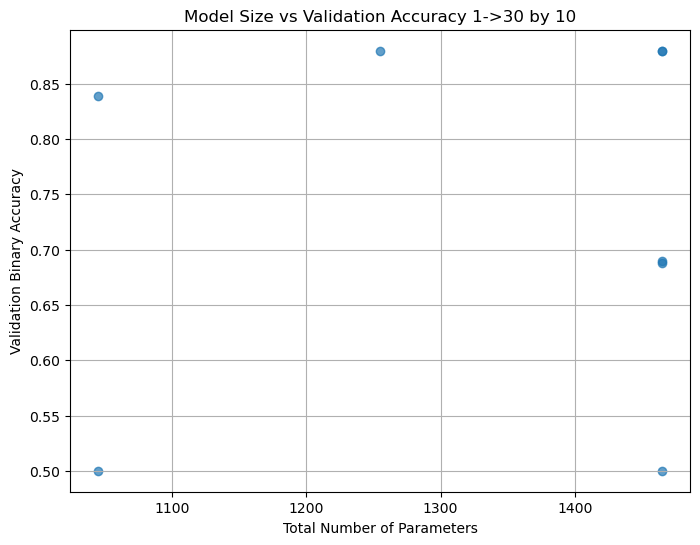

In [14]:
import os, json
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

base_dir = "/home/ryanmichaud/common_repo/Muon_Collider_Smart_Pixels/ryan/hp_search_1_30_by10"
results = []

def count_params_from_widths(r1: int) -> int:
    input1 = tf.keras.layers.Input(shape=(1,))
    input2 = tf.keras.layers.Input(shape=(1,))
    input3 = tf.keras.layers.Input(shape=(1,))
    input4 = tf.keras.layers.Input(shape=(1,))
    inputs = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

    x = tf.keras.layers.Dense(int(r1), activation='relu')(inputs)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(15, activation='relu')(x)
    x = tf.keras.layers.Dense(26, activation='relu')(x)
    x = tf.keras.layers.Dense(12, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model([input1, input2, input3, input4], out)
    return model.count_params()

for i in range(1, 120):
    trial_folder = os.path.join(base_dir, f"trial_{i:03d}")
    trial_json = os.path.join(trial_folder, "trial.json")
    if not os.path.exists(trial_json):
        continue

    try:
        with open(trial_json, "r") as f:
            data = json.load(f)

        # skip non-completed trials if present
        if data.get("status") and data["status"] != "COMPLETED":
            continue

        hp_values = data["hyperparameters"]["values"]
        r1 = hp_values["1"]

        obs = data["metrics"]["metrics"]["val_binary_accuracy"]["observations"]
        if not obs:
            continue
        val_acc = obs[0]["value"][0]

        total_params = count_params_from_widths(r1)

        results.append({
            "trial": i,
            "row1": r1,
            "params": total_params,
            "val_accuracy": val_acc
        })

    except (KeyError, IndexError, TypeError, json.JSONDecodeError) as e:
        print(f"Skipping trial_{i:03d}: {type(e).__name__}: {e}")
        continue

df = pd.DataFrame(results).sort_values("params")
print(df.head(), "\n")
print(f"Loaded {len(df)} trials")

plt.figure(figsize=(8, 6))
plt.scatter(df["params"], df["val_accuracy"], alpha=0.7)
plt.xlabel("Total Number of Parameters")
plt.ylabel("Validation Binary Accuracy")
plt.title("Model Size vs Validation Accuracy 1->30 by 10")
plt.grid(True)
plt.show()
